In [1]:
# very rough prototype to see how harmony interacts with L1/L2 granules,
# starting from Earthdata cloud clinic 'cookbook'.

import datetime as dt

from pprint import pprint
import xarray as xr

from harmony import BBox, Client, Collection, Request, LinkType
import s3fs

import matplotlib.pyplot as plt
import numpy as np

In [2]:
#setup Harmony client and Request object: a lat/lon box for one randomly selected day.

harmony_client = Client()

climcaps_short_name = "SNDRJ1IML2CCPRET"

# spatial box is (W, S, E, N) in degrees.
W, S, E, N = 10,50,15,55
request = Request(
    collection=Collection(id=climcaps_short_name),
    spatial=BBox(W, S, E, N),
    temporal={
    'start': dt.datetime(2021, 8, 1),
    'stop': dt.datetime(2021, 8, 2)   
    },
)

In [3]:
# submit and process request: I think this basically makes a bunch of subsetted nc4 files in a https served staging directory...

job_id = harmony_client.submit(request)
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


In [4]:
# print part of the JSON representation of the job result: note the href paths here are the on-the-fly created subset files.
data = harmony_client.result_json(job_id)
pprint(data['links'][1])

{'bbox': [10.1, 50.1, 15, 55],
 'href': 'https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/e33817c4-cd97-435c-9398-b2dd6586d192/14956762/SNDR.J1.CRIMSS.20210801T0048.m06.g009.L2_CLIMCAPS_RET.std.v02_53.G.211221121217_subsetted.nc4',
 'rel': 'data',
 'temporal': {'end': '2021-08-01T00:54:00.000Z',
              'start': '2021-08-01T00:48:00.000Z'},
 'title': 'SNDR.J1.CRIMSS.20210801T0048.m06.g009.L2_CLIMCAPS_RET.std.v02_53.G.211221121217_subsetted.nc4',
 'type': 'application/x-netcdf4'}


In [5]:
# get list of s3 URLs for the temporary subset files.
# (Note: the use of list is because the return from results_urls is a generator object)
results = harmony_client.result_urls(job_id, link_type=LinkType.s3)
urls = list(results)

print(urls)

['s3://harmony-prod-staging/public/e33817c4-cd97-435c-9398-b2dd6586d192/14956762/SNDR.J1.CRIMSS.20210801T0048.m06.g009.L2_CLIMCAPS_RET.std.v02_53.G.211221121217_subsetted.nc4', 's3://harmony-prod-staging/public/e33817c4-cd97-435c-9398-b2dd6586d192/14956763/SNDR.J1.CRIMSS.20210801T0230.m06.g026.L2_CLIMCAPS_RET.std.v02_53.G.211221121358_subsetted.nc4', 's3://harmony-prod-staging/public/e33817c4-cd97-435c-9398-b2dd6586d192/14956764/SNDR.J1.CRIMSS.20210801T1036.m06.g107.L2_CLIMCAPS_RET.std.v02_53.G.211221122559_subsetted.nc4', 's3://harmony-prod-staging/public/e33817c4-cd97-435c-9398-b2dd6586d192/14956765/SNDR.J1.CRIMSS.20210801T1042.m06.g108.L2_CLIMCAPS_RET.std.v02_53.G.211221122559_subsetted.nc4', 's3://harmony-prod-staging/public/e33817c4-cd97-435c-9398-b2dd6586d192/14956766/SNDR.J1.CRIMSS.20210801T1218.m06.g124.L2_CLIMCAPS_RET.std.v02_53.G.211221122659_subsetted.nc4']


In [6]:
# setup s3 (not sure what this does, why it is needed.)
creds = harmony_client.aws_credentials()
s3_fs = s3fs.S3FileSystem(
    key=creds['aws_access_key_id'],
    secret=creds['aws_secret_access_key'],
    token=creds['aws_session_token'],
    client_kwargs={'region_name':'us-west-2'},
)

In [7]:
# open all the subset files into one list.
ds_list = [xr.open_dataset(s3_fs.open(url, mode='rb')) for url in urls]

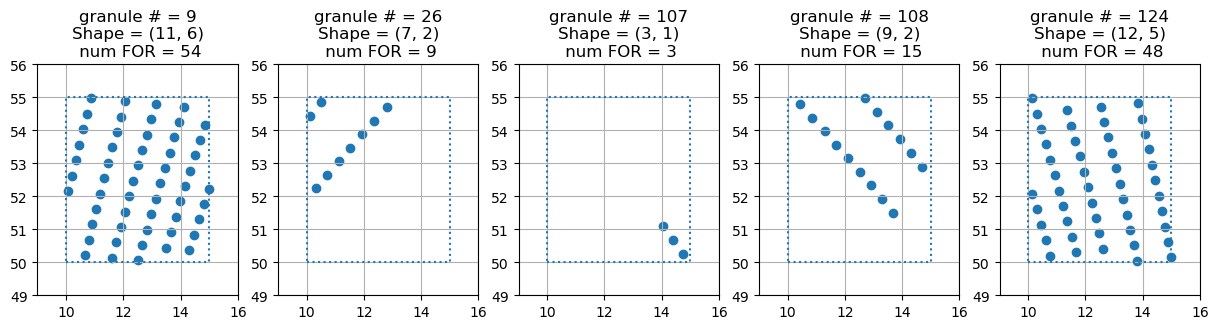

In [9]:
# I don't know a good way to plot these with xarray - and it might be tricky since these have weird layouts,
# at least from xarray's perspective.
# so, just dump into numpy arrays and scatter plot the old way.
# note the original bounding box request is overplotted with dots.

fig, ax_list = plt.subplots(1,len(ds_list),figsize=(15,3))

for ax, ds, url in zip(ax_list, ds_list, urls):
    lon = ds['lon'].to_numpy().flatten()
    lat = ds['lat'].to_numpy().flatten()
    ax.scatter(lon, lat)
    ax.set_xlim(W-1, E+1)
    ax.set_ylim(S-1, N+1)
    ax.grid(1)
    granule_num = int(url.split('/')[-1].split('.')[-7][1:])
    ax.set_title('granule # = {:d}\nShape = {:s}\n num FOR = {:d}'.format(granule_num, str(ds['lon'].shape), np.sum(np.isfinite(lon))))
    ax.plot([W,E,E,W,W], [S,S,N,N,S], ls=':')